In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Load the data ---

# Paths to the dataset
train_data_path = '/kaggle/input/final-augmented-dataset/aug-and-images-20240918T063356Z-001/aug-and-images'
train_mask_data_path = '/kaggle/input/final-augmented-dataset/aug-and-masks-20240918T063354Z-001/aug-and-masks'

# Load images and masks (limit to 100 for demonstration)
training_images = os.listdir(train_data_path)[0:1328]
training_masks = os.listdir(train_mask_data_path)[0:1328]

# Image dimensions
row, columns = 512, 512

# Initialize arrays for images and masks
x_train = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)
y_train = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

# Load and resize images and masks
for index, name in enumerate(training_images):
    img_path = os.path.join(train_data_path, name)
    mask_path = os.path.join(train_mask_data_path, name)
    
    if os.path.exists(mask_path):
        image = imread(img_path)
        mask = imread(mask_path)
        
        x_train[index] = image
        y_train[index] = mask


In [2]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
y_train = (y_train > .5).astype(np.float32)
# y_train = y_train.astype('bool')
# print(y_train.dtype)

In [3]:
x_train.shape

(1328, 512, 512, 3)

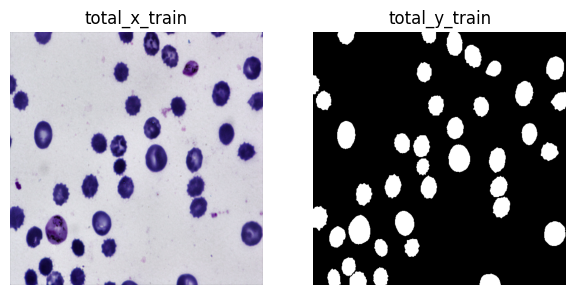

In [4]:
import matplotlib.pyplot as plt

# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(x_train[index])
plt.title('total_x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(y_train[index])
plt.title('total_y_train')
plt.axis('off')

# Display the images
plt.show()

In [5]:

import tensorflow as tf
import tensorflow.keras.backend as K

def dice_coef(a, b):

    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a 
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras

In [7]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply
from keras.layers import concatenate, Dropout
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Lambda
import keras.backend as K

In [8]:
y_train.shape

(1328, 512, 512, 3)

In [9]:

# y_train = y_train.reshape((1328, 3, 512, 512))
# x_train = x_train.reshape((1328, 3, 512, 512))


In [10]:
print(x_train.shape)
print(y_train.shape)

(1328, 512, 512, 3)
(1328, 512, 512, 3)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Custom Attention Block
def attention_block(x, g, inter_channel):
    # Theta_x
    theta_x = layers.Conv2D(inter_channel, kernel_size=1, strides=1)(x)
    
    # Phi_g
    phi_g = layers.Conv2D(inter_channel, kernel_size=1, strides=1)(g)

    # f
    f = layers.Activation('relu')(layers.add([theta_x, phi_g]))

    # Psi_f
    psi_f = layers.Conv2D(1, kernel_size=1, strides=1)(f)

    # Attention map
    rate = layers.Activation('sigmoid')(psi_f)

    # Attention output
    att_x = layers.multiply([x, rate])

    return att_x

# Attention U-Net Model
def attention_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(64, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(128, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(256, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(512, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(1024, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    a6 = attention_block(c4, u6, inter_channel=256)
    concat6 = layers.concatenate([u6, a6])
    c6 = layers.Conv2D(512, (3, 3), padding='same')(concat6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(512, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    a7 = attention_block(c3, u7, inter_channel=128)
    concat7 = layers.concatenate([u7, a7])
    c7 = layers.Conv2D(256, (3, 3), padding='same')(concat7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(256, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    a8 = attention_block(c2, u8, inter_channel=64)
    concat8 = layers.concatenate([u8, a8])
    c8 = layers.Conv2D(128, (3, 3), padding='same')(concat8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(128, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    a9 = attention_block(c1, u9, inter_channel=32)
    concat9 = layers.concatenate([u9, a9])
    c9 = layers.Conv2D(64, (3, 3), padding='same')(concat9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(64, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c9)  # Adjust for your output
#     outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c9) 
    model = Model(inputs, outputs)
    return model




In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
# --- Custom Metrics ---
def dice_coef(a, b):
    a_flat = K.flatten(a)
    b_flat = K.flatten(b)
    intersection = K.sum(a_flat * b_flat)
    return (2. * intersection + K.epsilon()) / (K.sum(a_flat) + K.sum(b_flat) + K.epsilon())

def dice_coef_loss(a, b):
    return 1 - dice_coef(a, b)

def jaccard_index(a, b):
    a_flat = K.flatten(a)
    b_flat = K.flatten(b)
    intersection = K.sum(a_flat * b_flat)
    union = K.sum(a_flat) + K.sum(b_flat) - intersection
    return intersection / (union + K.epsilon())

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

    #model.compile(optimizer='adam', loss='binary_crossentropy')

input_shape = (512, 512, 3)
model = attention_unet(input_shape)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 31,405,031 (119.80 MB)

 Trainable params: 31,393,255 (119.76 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [14]:
print(x_train.shape)
print(y_train.shape)

(1328, 512, 512, 3)
(1328, 512, 512, 3)


In [15]:
# x_train = np.transpose(x_train, (0, 2, 3, 1))  # New shape will be (100, 512, 512, 3)

# print(x_train.shape) 
# y_train = np.transpose(y_train, (0, 2, 3, 1))  # New shape will be (100, 512, 512, 3)

print(y_train.shape) 

(1328, 512, 512, 3)


In [16]:
earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,
history = model.fit(x_train[10:], y_train[10:], validation_split=0.2, batch_size=1, epochs=20,callbacks=[earlystopper, checkpoint])

Epoch 1/20


I0000 00:00:1727518719.186497     154 service.cc:145] XLA service 0x7ca2c8001fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727518719.186554     154 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   1/1054 ━━━━━━━━━━━━━━━━━━━━ 10:18:52 35s/step - dice_coef: 0.4827 - jaccard_index: 0.3182 - loss: 0.7773

I0000 00:00:1727518738.563225     154 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - dice_coef: 0.7202 - jaccard_index: 0.6033 - loss: 0.1980
Epoch 1: val_loss improved from inf to 0.18854, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 189s 146ms/step - dice_coef: 0.7202 - jaccard_index: 0.6034 - loss: 0.1979 - val_dice_coef: 0.7912 - val_jaccard_index: 0.7082 - val_loss: 0.1885
Epoch 2/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - dice_coef: 0.8326 - jaccard_index: 0.7665 - loss: 0.0744
Epoch 2: val_loss improved from 0.18854 to 0.10877, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 149s 141ms/step - dice_coef: 0.8327 - jaccard_index: 0.7665 - loss: 0.0744 - val_dice_coef: 0.8044 - val_jaccard_index: 0.7276 - val_loss: 0.1088
Epoch 3/20
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - dice_coef: 0.8482 - jaccard_index: 0.7939 - loss: 0.0672
Epoch 3: val_loss improved from 0.10877 to 0.08373, saving model to model.keras
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 149s 141ms/step - dice_coef: 0.8482 - jaccard

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


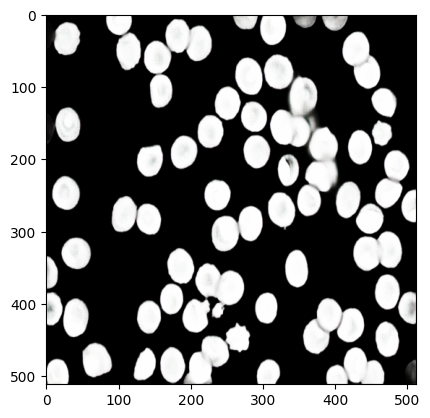

In [17]:
pred = model.predict(x_train[2:3])
pred = np.squeeze(pred)
plt.imshow(pred, cmap='gray')
plt.show()

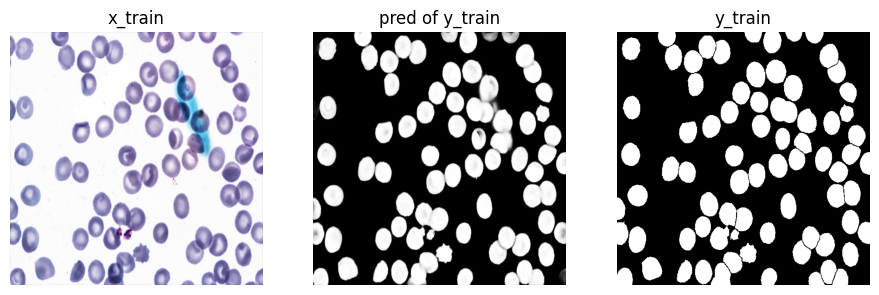

In [18]:
# Plot the first image from x_train
plt.figure(figsize=(15, 5))  # Set figure size to display all images properly
index=8
plt.subplot(1, 4, 1)  # (1 row, 3 columns, first subplot)
plt.imshow(np.squeeze(x_train[2:3]))
plt.title('x_train')
plt.axis('off')  # Hide axes

# Plot the first image from augmented_masks
plt.subplot(1, 4, 2)  # (1 row, 3 columns, third subplot)
plt.imshow(pred)
plt.title('pred of y_train')
plt.axis('off')

# Plot the first image from augmented_masks
plt.subplot(1, 4, 3)  # (1 row, 3 columns, third subplot)
plt.imshow(np.squeeze(y_train[2:3]))
plt.title('y_train')
plt.axis('off')

# Display the images
plt.show()

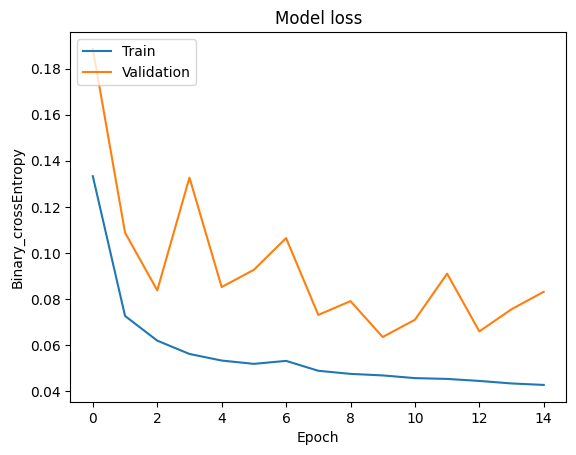

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

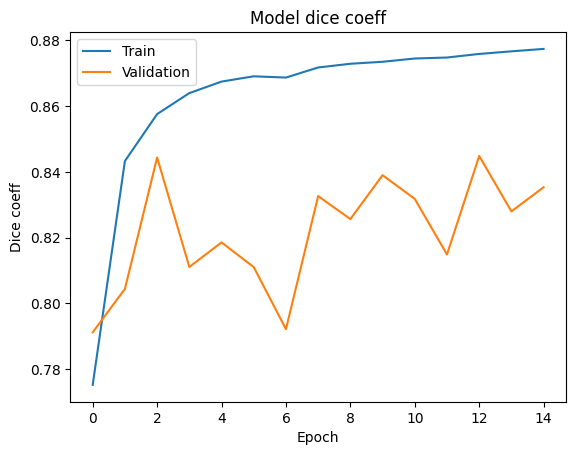

In [20]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

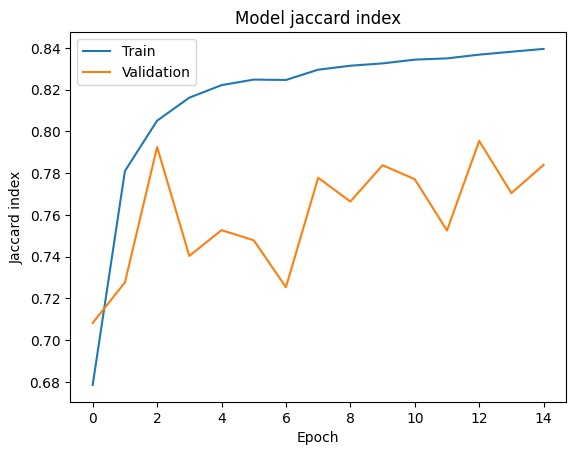

In [21]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
import tensorflow as tf
print(tf.__version__)

2.16.1
